# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\Sai charan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query("""
SELECT * FROM Reviews order by Time
""", con) 
final_train = pd.read_sql_query("""
SELECT * FROM Reviews order by Time 
limit cast(0.7*(select count(*) from Reviews) as integer) 
""" , con) 
final_test = pd.read_sql_query("""
SELECT * FROM Reviews order by Time desc
limit cast(0.3*(select count(*) from Reviews) as integer) 
""" , con)

In [3]:
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [4]:
print(final.shape)
print(final_train.shape)
print(final_test.shape)

(364171, 12)
(254919, 12)
(109251, 12)


In [5]:
final_train.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


# BAG OF WORDS

In [41]:
count_vect = CountVectorizer(min_df = 10) #in scikit-learn
final_train_X = count_vect.fit_transform(final_train['CleanedText'].values)
final_train_Y = final_train['Score'].values
final_test_X =  count_vect.transform(final_test['CleanedText'].values)
final_test_Y = final_test['Score']


The optimal value of alpha is 1.00000000.


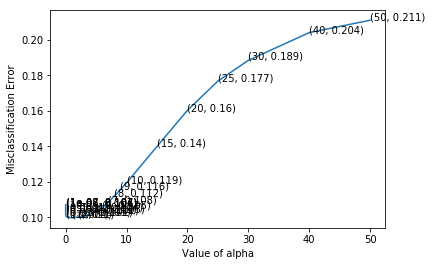

the misclassification error for each k value is :  [0.107 0.107 0.106 0.105 0.104 0.103 0.101 0.1   0.1   0.1   0.101 0.102
 0.103 0.105 0.108 0.112 0.116 0.119 0.14  0.16  0.177 0.189 0.204 0.211]


Text(0,0.5,'score')

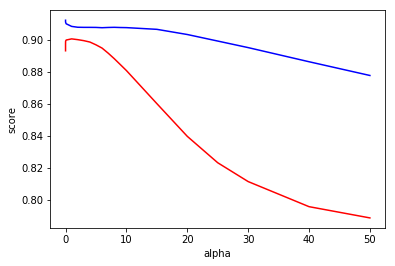

In [64]:
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.cross_validation import cross_val_score

X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(final_train_X, final_train_Y, 
                                                                     test_size=0.3, random_state=42)

myList = list(range(1,50))
neighbors = list(filter(lambda x: x % 1 == 0, myList))
neighbors = [0.00000001,0.0000001, 0.000001,0.00001,0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50]


cv_scores = []
training_scores =[]
for k in neighbors:
    nb = MultinomialNB(alpha=k)
    nb.fit(X_train, Y_train)
    #print(nb.predict(X_test[2:39]))
    scores = cross_val_score(nb, X_test, Y_test, cv=10, scoring='f1_weighted')
    scores_training = nb.fit(X_train, Y_train).score(X_train, Y_train)
    cv_scores.append(scores.mean())
    training_scores.append(scores_training)
    #print((nb))

MSE = [1 - x for x in cv_scores]
#determining best k
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %.8f.' % optimal_alpha)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))




In [65]:
# top 10  features
import operator
from nltk.probability import FreqDist, DictionaryProbDist, ELEProbDist, sum_logs
from nltk.classify.api import ClassifierI
from nltk.classify.naivebayes import NaiveBayesClassifier
nb = MultinomialNB(alpha=optimal_alpha).fit(final_train_X, final_train_Y)
pos_imp_features = nb.feature_log_prob_[1,:]
neg_imp_features = nb.feature_log_prob_[0,:]


imp_features = {}
feature_names= count_vect.get_feature_names()
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])
    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

Postive top 10 important features are:
('like', -4.427530558368252)
('tast', -4.497787402438359)
('good', -4.632813235704896)
('flavor', -4.65440245405914)
('love', -4.682616437325233)
('great', -4.703010551773813)
('use', -4.724763742115178)
('one', -4.781090186626004)
('product', -4.8673301827453255)
('tea', -4.874873609164702)


Negative top 10 important features are:
('tast', -4.198723008615145)
('like', -4.279964626319002)
('product', -4.447691836575137)
('one', -4.7226822725849456)
('flavor', -4.764495311529506)
('tri', -4.8737934363943065)
('would', -4.874299381257112)
('good', -5.030744075840399)
('coffe', -5.0565197285980155)
('use', -5.063527323414599)


In [66]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    #representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    #representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Accuracy of the model at optimal hyperparameter alpha = 1 is:  89.158909%
Confusion matrix for the model is:


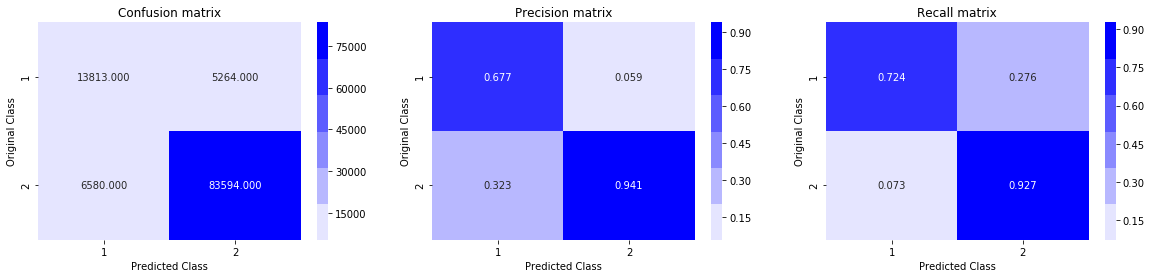

f1 score value for   the model is: 0.8929979543924229
precision score  for   the model is: 0.940759413896329


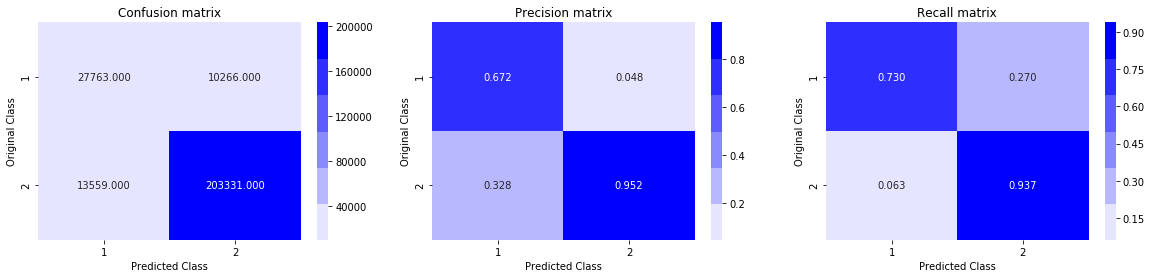

Accuracy of the model at optimal hyperparameter alpha = 1 is:  90.653894%
f1 score value for   the model is: 0.9081207535852495
precision score  for   the model is: 0.9519375272124608


In [67]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
nb = MultinomialNB(alpha=optimal_alpha).fit(final_train_X, final_train_Y)
Y_pred = nb.predict(final_test_X)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)
f1score= f1_score(final_test_Y, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(final_test_Y, Y_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = nb.predict(final_train_X)
Y_train_accuracy =accuracy_score(final_train_Y, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(final_train_Y, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(final_train_Y, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(final_train_Y, y_train_pred,pos_label='positive')
print('precision score  for   the model is: %s'% precisionscore)







The optimal value of alpha is 4.00000000.


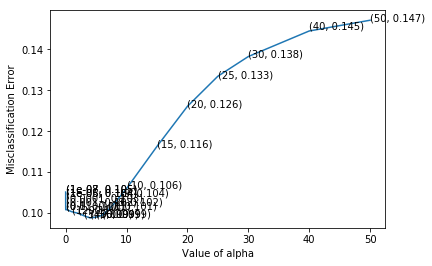

the misclassification error for each k value is :  [0.105 0.105 0.104 0.104 0.103 0.102 0.101 0.101 0.1   0.1   0.099 0.099
 0.099 0.099 0.101 0.102 0.104 0.106 0.116 0.126 0.133 0.138 0.145 0.147]


Text(0,0.5,'score')

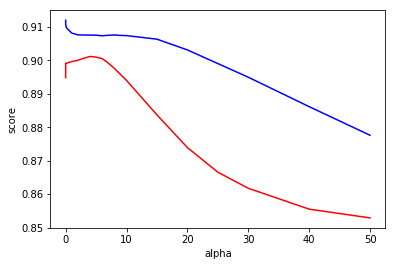

In [68]:
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.cross_validation import cross_val_score

X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(final_train_X, final_train_Y, 
                                                                     test_size=0.3, random_state=42)

myList = list(range(1,50))
neighbors = list(filter(lambda x: x % 1 == 0, myList))
neighbors = [0.00000001,0.0000001, 0.000001,0.00001,0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50]


cv_scores = []
training_scores =[]
for k in neighbors:
    nb = MultinomialNB(alpha=k)
    nb.fit(X_train, Y_train)
    #print(nb.predict(X_test[2:39]))
    scores = cross_val_score(nb, X_test, Y_test, cv=10, scoring='f1_micro')
    scores_training = nb.fit(X_train, Y_train).score(X_train, Y_train)
    cv_scores.append(scores.mean())
    training_scores.append(scores_training)
    #print((nb))

MSE = [1 - x for x in cv_scores]
#determining best k
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %.8f.' % optimal_alpha)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))
plt.plot(neighbors, cv_scores, 'r')
plt.plot(neighbors, training_scores, 'b')
plt.xlabel('alpha')
plt.ylabel('score')

In [69]:
# top 10  features
import operator
from nltk.probability import FreqDist, DictionaryProbDist, ELEProbDist, sum_logs
from nltk.classify.api import ClassifierI
from nltk.classify.naivebayes import NaiveBayesClassifier
nb = MultinomialNB(alpha=optimal_alpha).fit(final_train_X, final_train_Y)
pos_imp_features = nb.feature_log_prob_[1,:]
neg_imp_features = nb.feature_log_prob_[0,:]


imp_features = {}
feature_names= count_vect.get_feature_names()
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])
    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

Postive top 10 important features are:
('like', -4.432194857449268)
('tast', -4.502449438160008)
('good', -4.63747044864796)
('flavor', -4.659058833698637)
('love', -4.687271700484851)
('great', -4.707664988059761)
('use', -4.7294172776390315)
('one', -4.7857412966436925)
('product', -4.871977304053084)
('tea', -4.8795203649427314)


Negative top 10 important features are:
('tast', -4.22279600149343)
('like', -4.304026723247965)
('product', -4.471728433834571)
('one', -4.74666660312802)
('flavor', -4.7884703596121145)
('tri', -4.897742305403451)
('would', -4.898248122308521)
('good', -5.054649977918352)
('coffe', -5.080417907164815)
('use', -5.087423367562755)


Accuracy of the model at optimal hyperparameter alpha = 4 is:  89.199184%
Confusion matrix for the model is:


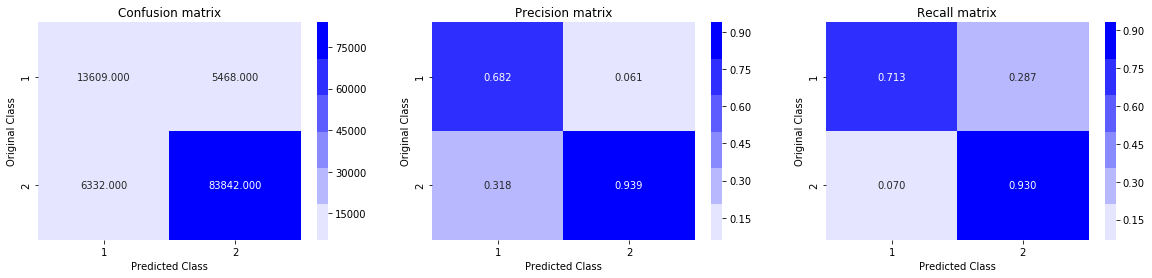

f1 score value for   the model is: 0.8919918353150086
precision score  for   the model is: 0.9387750531855336


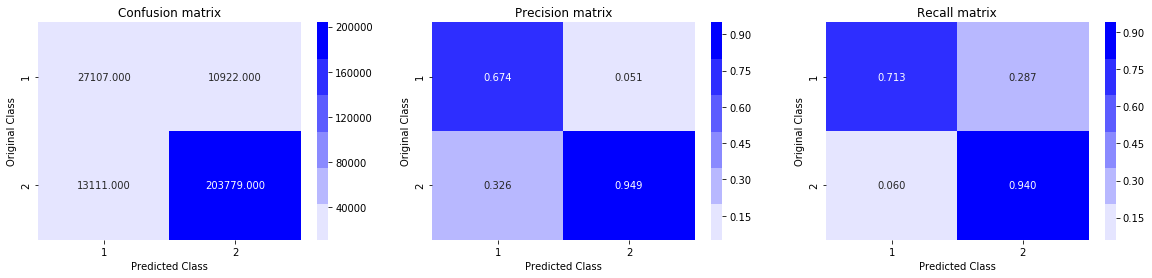

Accuracy of the model at optimal hyperparameter alpha = 4 is:  90.572299%
f1 score value for   the model is: 0.9057229943629153
precision score  for   the model is: 0.9491292541720812


In [70]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
nb = MultinomialNB(alpha=optimal_alpha).fit(final_train_X, final_train_Y)
Y_pred = nb.predict(final_test_X)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)
f1score= f1_score(final_test_Y, Y_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(final_test_Y, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = nb.predict(final_train_X)
Y_train_accuracy =accuracy_score(final_train_Y, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(final_train_Y, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(final_train_Y, y_train_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(final_train_Y, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)







The optimal value of alpha is 4.00000000.


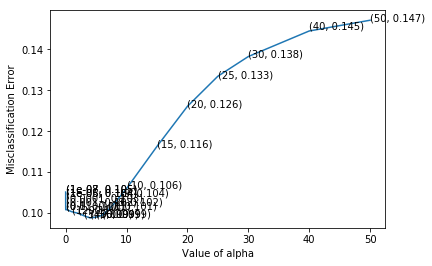

the misclassification error for each k value is :  [0.105 0.105 0.104 0.104 0.103 0.102 0.101 0.101 0.1   0.1   0.099 0.099
 0.099 0.099 0.101 0.102 0.104 0.106 0.116 0.126 0.133 0.138 0.145 0.147]


Text(0,0.5,'score')

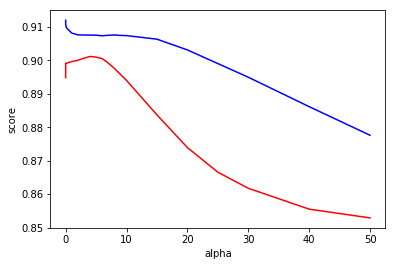

In [46]:
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.cross_validation import cross_val_score

X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(final_train_X, final_train_Y, 
                                                                     test_size=0.3, random_state=42)

myList = list(range(1,50))
neighbors = list(filter(lambda x: x % 1 == 0, myList))
neighbors = [0.00000001,0.0000001, 0.000001,0.00001,0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50]


cv_scores = []
training_scores =[]
for k in neighbors:
    nb = MultinomialNB(alpha=k)
    nb.fit(X_train, Y_train)
    #print(nb.predict(X_test[2:39]))
    scores = cross_val_score(nb, X_test, Y_test, cv=10, scoring='precision_micro')
    scores_training = nb.fit(X_train, Y_train).score(X_train, Y_train)
    cv_scores.append(scores.mean())
    training_scores.append(scores_training)                                            
    #print((nb))

MSE = [1 - x for x in cv_scores]
#determining best k
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %.8f.' % optimal_alpha)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))
plt.plot(neighbors, cv_scores, 'r')
plt.plot(neighbors, training_scores, 'b')
plt.xlabel('alpha')
plt.ylabel('score')                                                     
                                                     
                                                     
                                                    

In [47]:
# top 10  features
import operator
from nltk.probability import FreqDist, DictionaryProbDist, ELEProbDist, sum_logs
from nltk.classify.api import ClassifierI
from nltk.classify.naivebayes import NaiveBayesClassifier
nb = MultinomialNB(alpha=optimal_alpha).fit(final_train_X, final_train_Y)
pos_imp_features = nb.feature_log_prob_[1,:]
neg_imp_features = nb.feature_log_prob_[0,:]


imp_features = {}
feature_names= count_vect.get_feature_names()
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])
    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

Postive top 10 important features are:
('like', -4.432194857449268)
('tast', -4.502449438160008)
('good', -4.63747044864796)
('flavor', -4.659058833698637)
('love', -4.687271700484851)
('great', -4.707664988059761)
('use', -4.7294172776390315)
('one', -4.7857412966436925)
('product', -4.871977304053084)
('tea', -4.8795203649427314)


Negative top 10 important features are:
('tast', -4.22279600149343)
('like', -4.304026723247965)
('product', -4.471728433834571)
('one', -4.74666660312802)
('flavor', -4.7884703596121145)
('tri', -4.897742305403451)
('would', -4.898248122308521)
('good', -5.054649977918352)
('coffe', -5.080417907164815)
('use', -5.087423367562755)


Accuracy of the model at optimal hyperparameter alpha = 4 is:  89.199184%
Confusion matrix for the model is:


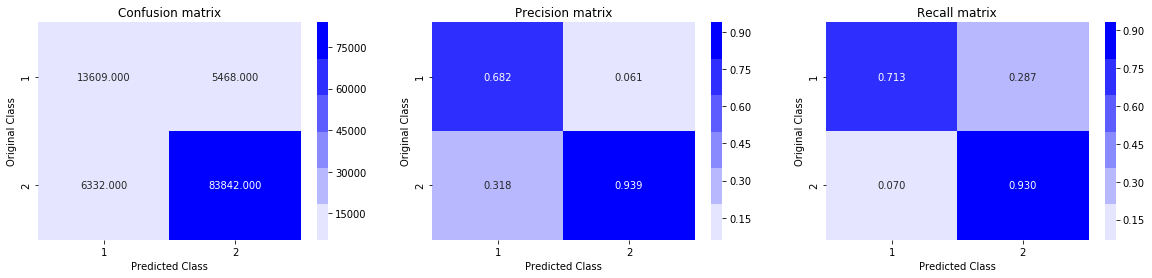

f1 score value for   the model is: 0.9342559782487576
precision score  for   the model is: 0.8919918353150086


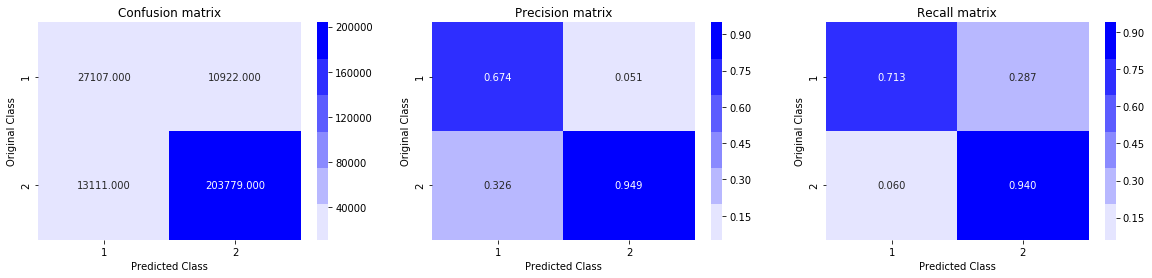

Accuracy of the model at optimal hyperparameter alpha = 4 is:  90.572299%
f1 score value for   the model is: 0.9443153355839209
precision score  for   the model is: 0.9057229943629153


In [49]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
nb = MultinomialNB(alpha=optimal_alpha).fit(final_train_X, final_train_Y)
Y_pred = nb.predict(final_test_X)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)
f1score= f1_score(final_test_Y, Y_pred,pos_label='positive')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(final_test_Y, Y_pred, average='micro')
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = nb.predict(final_train_X)
Y_train_accuracy =accuracy_score(final_train_Y, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(final_train_Y, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(final_train_Y, y_train_pred,pos_label='positive')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(final_train_Y, y_train_pred, average='micro')
print('precision score  for   the model is: %s'% precisionscore)






# TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df = 5)
final_tf_idf_train_X = tf_idf_vect.fit_transform(final_train['CleanedText'].values)
final_tf_idf_train_Y = final_train['Score'].values
final_tf_idf_test_X = tf_idf_vect.transform(final_test['CleanedText'].values)
final_tf_idf_test_Y = final_test['Score'].values
print(final_tf_idf_train_X.get_shape())
print(final_tf_idf_train_Y.shape)
print(final_tf_idf_test_X.get_shape())
print(final_tf_idf_test_Y.shape)

(254919, 303779)
(254919,)
(109251, 303779)
(109251,)


In [28]:
features = tf_idf_vect.get_feature_names()
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf_train_X[1,:].toarray()[0],features,25)
print(top_tfidf)

          feature     tfidf
0            book  0.266005
1      along book  0.246784
2       seri book  0.246784
3        see show  0.235970
4      turn whole  0.230415
5    later bought  0.226019
6      bought day  0.219277
7   purchas along  0.218336
8      rememb see  0.218336
9         televis  0.198755
10     someth use  0.195701
11           song  0.191167
12      preschool  0.187435
13         thirti  0.176366
14          teach  0.175865
15           seri  0.173858
16        student  0.154102
17         sister  0.135480
18            air  0.131232
19         school  0.129849
20          child  0.128539
21       children  0.123706
22         tradit  0.120614
23           show  0.118149
24          later  0.113438


C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-p

C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-p

C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-p

C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-p

C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Sai charan\Anaconda3\lib\site-p


The optimal value of alpha is 0.10000000.


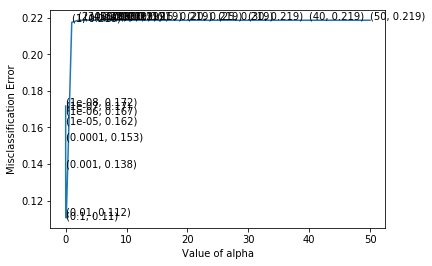

the misclassification error for each k value is :  [0.172 0.17  0.167 0.162 0.153 0.138 0.112 0.11  0.218 0.219 0.219 0.219
 0.219 0.219 0.219 0.219 0.219 0.219 0.219 0.219 0.219 0.219 0.219 0.219]


Text(0,0.5,'score')

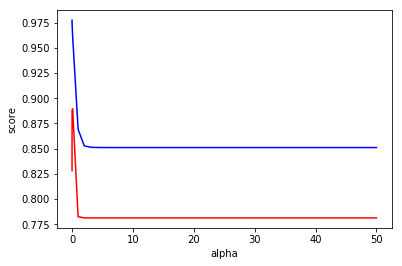

In [50]:
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.cross_validation import cross_val_score
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(final_tf_idf_train_X, final_tf_idf_train_Y, 
                                                                     test_size=0.3, random_state=42)

myList = list(range(1,50))
neighbors = list(filter(lambda x: x % 1 == 0, myList))
neighbors = [0.00000001,0.0000001, 0.000001,0.00001,0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50]


cv_scores = []
training_scores=[]

for k in neighbors:
    nb = MultinomialNB(alpha=k)
    nb.fit(X_train, Y_train)
    scores = cross_val_score(nb, X_test, Y_test, cv=10, scoring='f1_weighted')
    scores_training = nb.fit(X_train, Y_train).score(X_train, Y_train)
    training_scores.append(scores_training)
    cv_scores.append(scores.mean())
    
MSE = [1 - x for x in cv_scores]
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %.8f.' % optimal_alpha)
 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))
plt.plot(neighbors, cv_scores, 'r')
plt.plot(neighbors, training_scores, 'b')
plt.xlabel('alpha')
plt.ylabel('score') 

In [51]:
#finding top 10 features
import operator
from nltk.probability import FreqDist, DictionaryProbDist, ELEProbDist, sum_logs
from nltk.classify.api import ClassifierI
from nltk.classify.naivebayes import NaiveBayesClassifier
nb = MultinomialNB(alpha=optimal_alpha).fit(final_tf_idf_train_X, final_tf_idf_train_Y)
pos_imp_features = nb.feature_log_prob_[1,:]
neg_imp_features = nb.feature_log_prob_[0,:]


imp_features = {}
feature_names= tf_idf_vect.get_feature_names()
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])
    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

Postive top 10 important features are:
('great', -6.001136608974116)
('love', -6.008649423931306)
('tast', -6.055539584683453)
('like', -6.060090580105459)
('good', -6.064613236182131)
('tea', -6.070494802247866)
('flavor', -6.12868901015306)
('coffe', -6.166652634844438)
('use', -6.216005675613195)
('product', -6.229773439881506)


Negative top 10 important features are:
('tast', -5.800289769448615)
('like', -5.938861625972881)
('product', -5.963807213532568)
('would', -6.274766069145562)
('flavor', -6.3051998062458265)
('one', -6.311414767697251)
('coffe', -6.317974440047535)
('tri', -6.425499918604087)
('order', -6.44011181096098)
('buy', -6.444937059209161)


Accuracy of the model at optimal hyperparameter alpha = 0 is:  89.181792%
Confusion matrix for the model is:


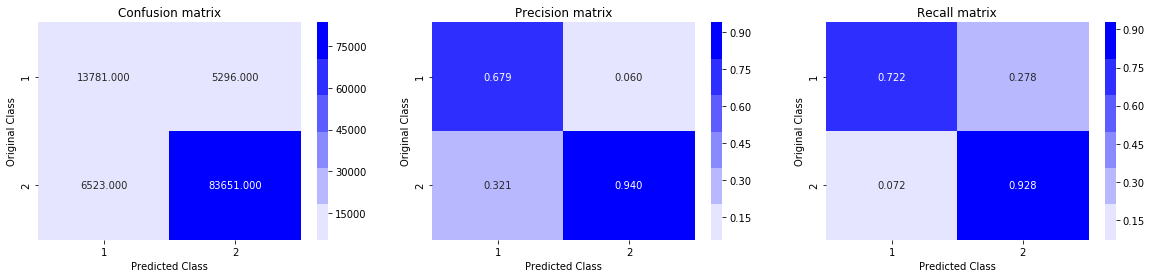

f1 score value for   the model is: 0.8931327168313815
precision score  for   the model is: 0.9404589249777958


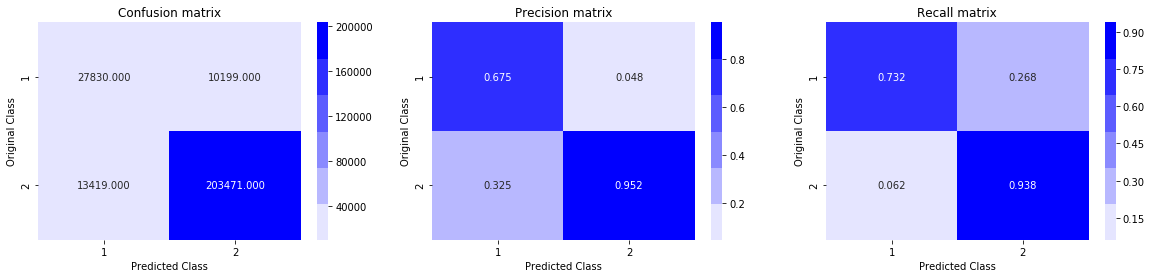

Accuracy of the model at optimal hyperparameter alpha = 0 is:  90.735096%
f1 score value for   the model is: 0.9088860612162143
precision score  for   the model is: 0.952267515327374


In [53]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
nb = MultinomialNB(alpha=optimal_alpha).fit(final_train_X, final_train_Y)
Y_pred = nb.predict(final_test_X)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)
f1score= f1_score(final_test_Y, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(final_test_Y, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = nb.predict(final_train_X)
Y_train_accuracy =accuracy_score(final_train_Y, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(final_train_Y, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(final_train_Y, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(final_train_Y, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)







The optimal value of alpha is 0.10000000.


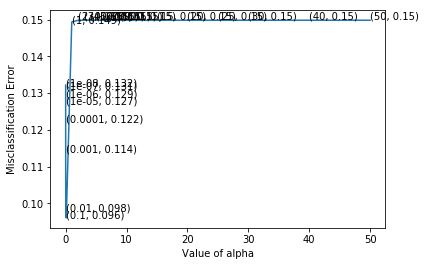

the misclassification error for each k value is :  [0.132 0.131 0.129 0.127 0.122 0.114 0.098 0.096 0.149 0.15  0.15  0.15
 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15 ]


Text(0,0.5,'score')

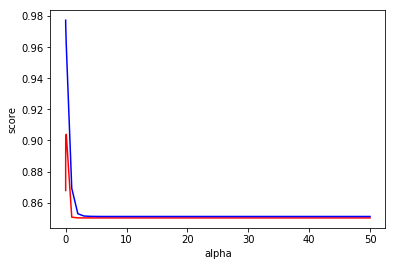

In [54]:
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.cross_validation import cross_val_score
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(final_tf_idf_train_X, final_tf_idf_train_Y, 
                                                                     test_size=0.3, random_state=42)

myList = list(range(1,50))
neighbors = list(filter(lambda x: x % 1 == 0, myList))
neighbors = [0.00000001,0.0000001, 0.000001,0.00001,0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50]


cv_scores = []
training_scores=[]
for k in neighbors:
    nb = MultinomialNB(alpha=k)
    nb.fit(X_train, Y_train)
    scores = cross_val_score(nb, X_test, Y_test, cv=10, scoring='f1_micro')
    scores_training = nb.fit(X_train, Y_train).score(X_train, Y_train)
    training_scores.append(scores_training)
    cv_scores.append(scores.mean())
    
MSE = [1 - x for x in cv_scores]
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %.8f.' % optimal_alpha)
 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))
plt.plot(neighbors, cv_scores, 'r')
plt.plot(neighbors, training_scores, 'b')
plt.xlabel('alpha')
plt.ylabel('score')

In [55]:
#finding top 10 features
import operator
from nltk.probability import FreqDist, DictionaryProbDist, ELEProbDist, sum_logs
from nltk.classify.api import ClassifierI
from nltk.classify.naivebayes import NaiveBayesClassifier
nb = MultinomialNB(alpha=optimal_alpha).fit(final_tf_idf_train_X, final_tf_idf_train_Y)
pos_imp_features = nb.feature_log_prob_[1,:]
neg_imp_features = nb.feature_log_prob_[0,:]


imp_features = {}
feature_names= tf_idf_vect.get_feature_names()
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])
    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

Postive top 10 important features are:
('great', -6.001136608974116)
('love', -6.008649423931306)
('tast', -6.055539584683453)
('like', -6.060090580105459)
('good', -6.064613236182131)
('tea', -6.070494802247866)
('flavor', -6.12868901015306)
('coffe', -6.166652634844438)
('use', -6.216005675613195)
('product', -6.229773439881506)


Negative top 10 important features are:
('tast', -5.800289769448615)
('like', -5.938861625972881)
('product', -5.963807213532568)
('would', -6.274766069145562)
('flavor', -6.3051998062458265)
('one', -6.311414767697251)
('coffe', -6.317974440047535)
('tri', -6.425499918604087)
('order', -6.44011181096098)
('buy', -6.444937059209161)


Accuracy of the model at optimal hyperparameter alpha = 0 is:  89.181792%
Confusion matrix for the model is:


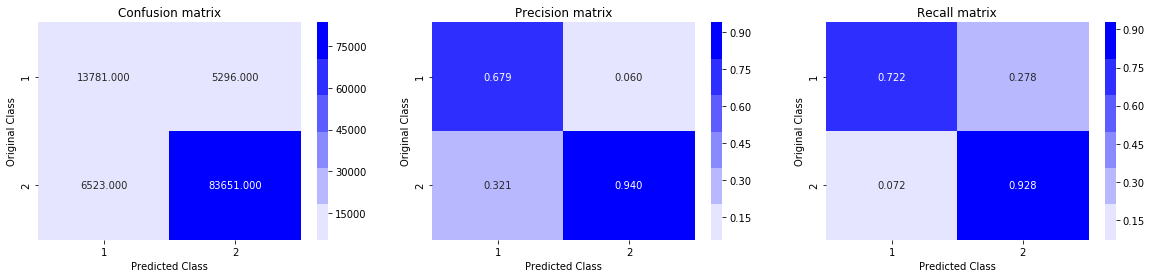

f1 score value for   the model is: 0.8918179238633971
precision score  for   the model is: 0.9404589249777958


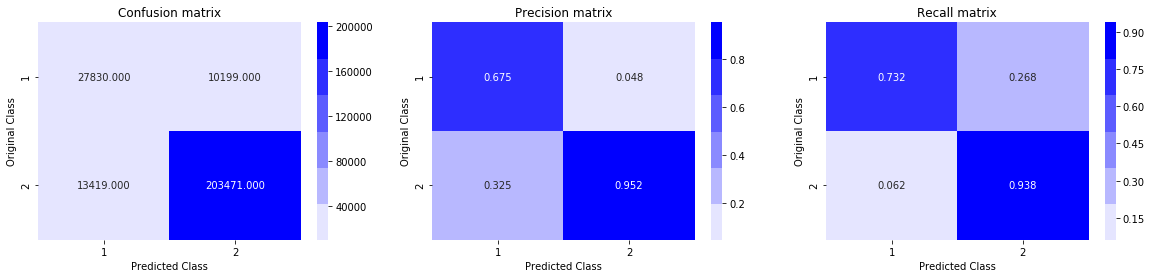

Accuracy of the model at optimal hyperparameter alpha = 0 is:  90.735096%
f1 score value for   the model is: 0.9073509624625862
precision score  for   the model is: 0.952267515327374


In [56]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
nb = MultinomialNB(alpha=optimal_alpha).fit(final_train_X, final_train_Y)
Y_pred = nb.predict(final_test_X)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)
f1score= f1_score(final_test_Y, Y_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(final_test_Y, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = nb.predict(final_train_X)
Y_train_accuracy =accuracy_score(final_train_Y, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(final_train_Y, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(final_train_Y, y_train_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(final_train_Y, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)







The optimal value of alpha is 0.10000000.


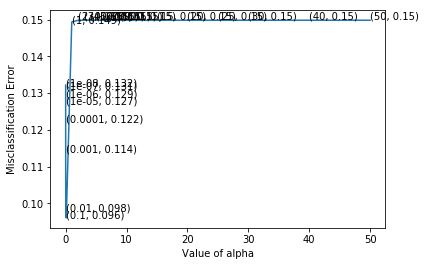

the misclassification error for each k value is :  [0.132 0.131 0.129 0.127 0.122 0.114 0.098 0.096 0.149 0.15  0.15  0.15
 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15 ]


Text(0,0.5,'score')

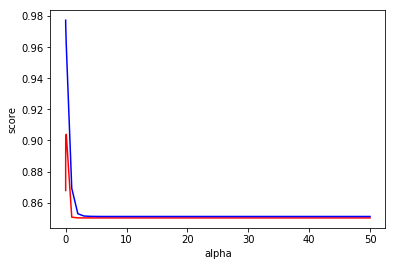

In [57]:
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.cross_validation import cross_val_score
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(final_tf_idf_train_X, final_tf_idf_train_Y, 
                                                                     test_size=0.3, random_state=42)

myList = list(range(1,50))
neighbors = list(filter(lambda x: x % 1 == 0, myList))
neighbors = [0.00000001,0.0000001, 0.000001,0.00001,0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50]


cv_scores = []
training_scores=[]
for k in neighbors:
    nb = MultinomialNB(alpha=k)
    nb.fit(X_train, Y_train)
    scores = cross_val_score(nb, X_test, Y_test, cv=10, scoring='precision_micro')
    scores_training = nb.fit(X_train, Y_train).score(X_train, Y_train)
    training_scores.append(scores_training)
    
    cv_scores.append(scores.mean())
    
MSE = [1 - x for x in cv_scores]
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %.8f.' % optimal_alpha)
 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))
plt.plot(neighbors, cv_scores, 'r')
plt.plot(neighbors, training_scores, 'b')
plt.xlabel('alpha')
plt.ylabel('score')

In [58]:
#finding top 10 features
import operator
from nltk.probability import FreqDist, DictionaryProbDist, ELEProbDist, sum_logs
from nltk.classify.api import ClassifierI
from nltk.classify.naivebayes import NaiveBayesClassifier
nb = MultinomialNB(alpha=optimal_alpha).fit(final_tf_idf_train_X, final_tf_idf_train_Y)
pos_imp_features = nb.feature_log_prob_[1,:]
neg_imp_features = nb.feature_log_prob_[0,:]


imp_features = {}
feature_names= tf_idf_vect.get_feature_names()
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])
    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

Postive top 10 important features are:
('great', -6.001136608974116)
('love', -6.008649423931306)
('tast', -6.055539584683453)
('like', -6.060090580105459)
('good', -6.064613236182131)
('tea', -6.070494802247866)
('flavor', -6.12868901015306)
('coffe', -6.166652634844438)
('use', -6.216005675613195)
('product', -6.229773439881506)


Negative top 10 important features are:
('tast', -5.800289769448615)
('like', -5.938861625972881)
('product', -5.963807213532568)
('would', -6.274766069145562)
('flavor', -6.3051998062458265)
('one', -6.311414767697251)
('coffe', -6.317974440047535)
('tri', -6.425499918604087)
('order', -6.44011181096098)
('buy', -6.444937059209161)


Accuracy of the model at optimal hyperparameter alpha = 0 is:  89.181792%
Confusion matrix for the model is:


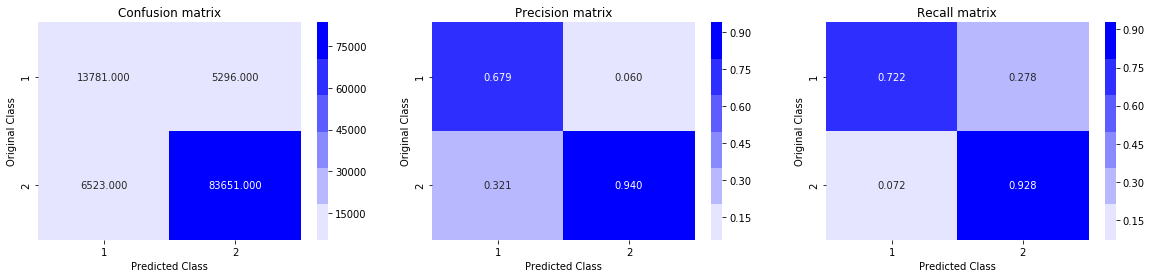

f1 score value for   the model is: 0.9340166702954986
precision score  for   the model is: 0.8918179238633971


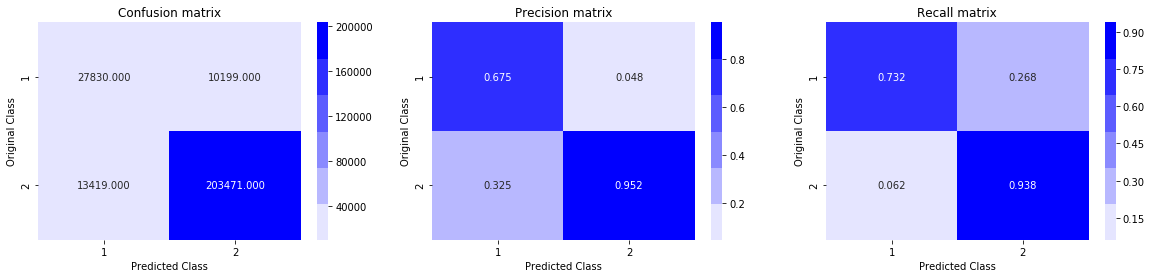

Accuracy of the model at optimal hyperparameter alpha = 0 is:  90.735096%
f1 score value for   the model is: 0.9451458565589
precision score  for   the model is: 0.9073509624625862


In [63]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
nb = MultinomialNB(alpha=optimal_alpha).fit(final_train_X, final_train_Y)
Y_pred = nb.predict(final_test_X)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)
f1score= f1_score(final_test_Y, Y_pred, pos_label='positive')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(final_test_Y, Y_pred, average='micro',)
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = nb.predict(final_train_X)
Y_train_accuracy =accuracy_score(final_train_Y, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(final_train_Y, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(final_train_Y, y_train_pred,pos_label='positive' )
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(final_train_Y, y_train_pred, average='micro',)
print('precision score  for   the model is: %s'% precisionscore)






In [71]:
from prettytable import PrettyTable

# Names of models
featurization = ['Bag of Words','Bag of Words','Bag of Words','TFIDF ','TFIDF ','TFIDF ']
hyperparameter=['f1_weighted','f1_micro','precision_micro','f1_weighted','f1_micro','precision_micro']

# Training accuracies
F1score= [0.8929,0.8919,0.9342,0.8931,0.9050,0.9340]
accuracy = [89.15,89.19,89.19,89.18,89.18,89.18]
alpha=[1,4,4,0.1,0.1,0.1]
precision=[0.9407,0.9387,0.8919,0.9404,0.9404,0.8918]
numbering = [1,2,3,4,5,6]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",featurization)
ptable.add_column("alpha",alpha)
ptable.add_column("hyper parameter",hyperparameter)

ptable.add_column("accuracy",accuracy)
ptable.add_column("score",F1score)
ptable.add_column("precision",precision)
# Printing the Table
print(ptable)

+-------+--------------+-------+-----------------+----------+--------+-----------+
| S.NO. |    MODEL     | alpha | hyper parameter | accuracy | score  | precision |
+-------+--------------+-------+-----------------+----------+--------+-----------+
|   1   | Bag of Words |   1   |   f1_weighted   |  89.15   | 0.8929 |   0.9407  |
|   2   | Bag of Words |   4   |     f1_micro    |  89.19   | 0.8919 |   0.9387  |
|   3   | Bag of Words |   4   | precision_micro |  89.19   | 0.9342 |   0.8919  |
|   4   |    TFIDF     |  0.1  |   f1_weighted   |  89.18   | 0.8931 |   0.9404  |
|   5   |    TFIDF     |  0.1  |     f1_micro    |  89.18   | 0.905  |   0.9404  |
|   6   |    TFIDF     |  0.1  | precision_micro |  89.18   | 0.934  |   0.8918  |
+-------+--------------+-------+-----------------+----------+--------+-----------+
